In [62]:
# Define model
import keras.layers as L
import keras.losses as losses
import keras.models as M
import keras.optimizers as opt
from keras.utils import to_categorical

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy 
import re
from sklearn import cross_validation, metrics

%matplotlib inline

In [64]:
# Plot settings
plt.style.use('seaborn-dark-palette')
plt.interactive(True)
plt.rcParams['figure.figsize'] = (20, 8)

In [65]:
df = pd.read_csv('../../data/1900-01-01-2019-02-18-India.csv')

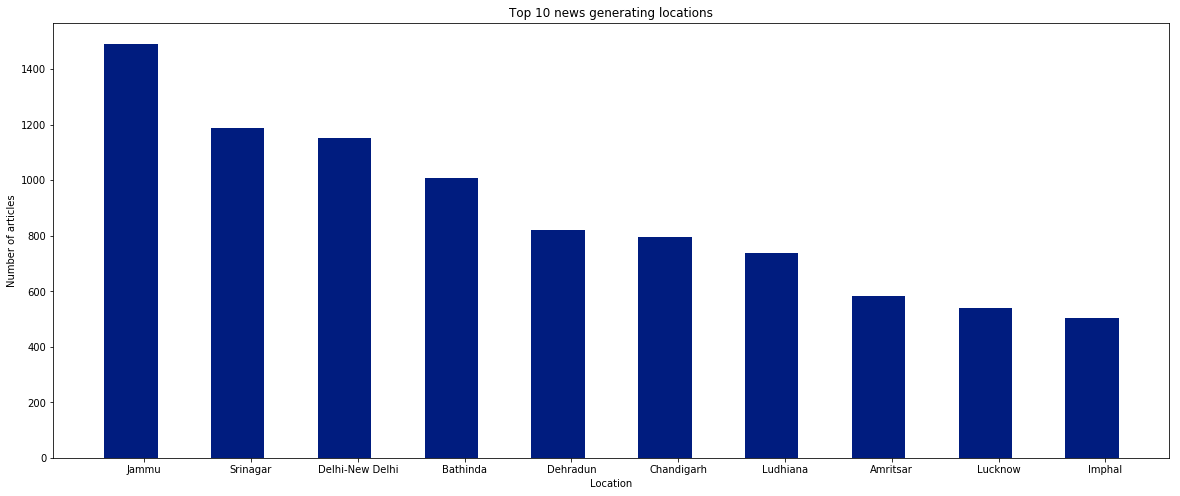

In [66]:
counter = Counter(df.location)
counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:10]
counter = np.array(counter)

places, counts = counter[:, 0].tolist(), counter[:, 1].astype(np.float32)
indices = np.arange(len(counts))
width = 1

plt.xlabel("Location")
plt.ylabel("Number of articles")
plt.interactive(True)

plt.xticks(indices + 0.125, places)
plt.title("Top 10 news generating locations")
_ = plt.bar(indices, counts, 0.5)

In [67]:
df['event_date'] = pd.to_datetime(df['event_date'])
df.sort_values(by=['event_date'], inplace=True)

In [68]:
dates = pd.date_range(start=df.iloc[0]['event_date'], end=df.iloc[-1]['event_date'])
print("Number of days -", len(dates))

Number of days - 1136


In [69]:
dates[0], dates[-1]

(Timestamp('2016-01-01 00:00:00', freq='D'),
 Timestamp('2019-02-09 00:00:00', freq='D'))

In [70]:
df = df[df['location'] == "Chennai"]

num_events = np.zeros(len(dates))
i = 0
for date in dates:
    num_events[i] += len(df[df['event_date'] == date])
    i += 1

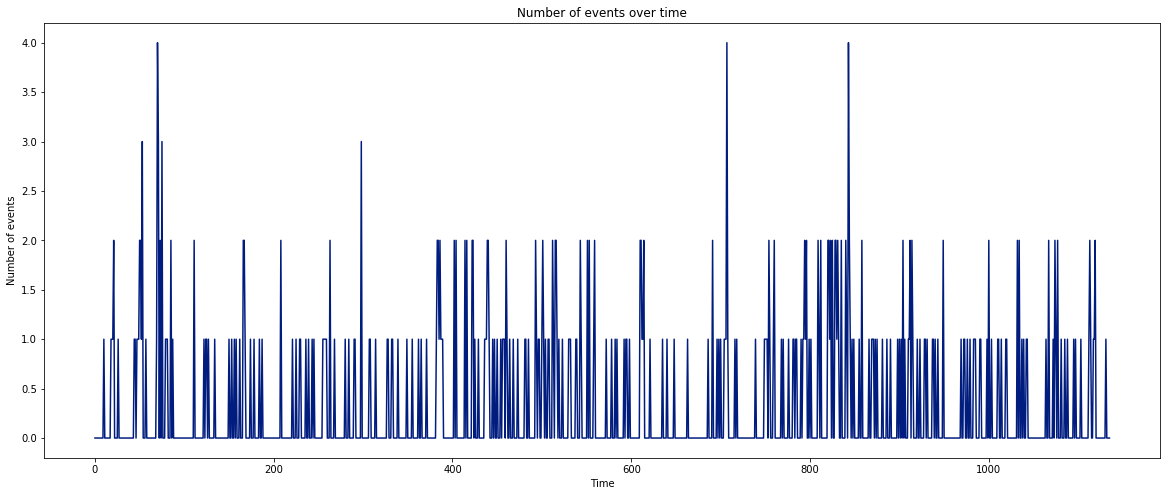

In [71]:
plt.title("Number of events over time")
plt.xlabel("Time")
plt.ylabel("Number of events")
_ = plt.plot(num_events)

In [72]:
news_articles = df.notes

In [73]:
def get_glove_dict():
    """
    Inputs - None
    
    Returns - Dict below
    
    Create a dict with word as key and word vector as value
    """
    d = {}
    f = open("../../glove_vectors/glove.6B.100d.txt", 'r')
    for row in f:
        row = row.replace('\n', '').split(" ")
        word = row[0]
        vector = np.array([float(x) for x in row[1:]])
        d[word] = vector
    f.close()
    return d

def generate_labels(num_events, num_days=2, days_window=2):
    """
    Inputs - 
        num_events - as generated as above 
        num_days - the number of days to after which we 
                   look for the occurence of an event.
                   Basically, the future
        day_window - If an event occurs in a window of days
                     after num_days
    
    Returns - Returns labels generated as below
    
    Generate labels by using the future events, basically
    look-ahead to create labels. If an event occurs from 
    i to i + num_days, then label is 1.0 else 0.0
    """
    n = len(num_events)
    labels = np.zeros(n - num_days - days_window)
    for i in range(n - num_days - days_window):
        labels[i] = 1.0 if sum(num_events[i + num_days: i + num_days + days_window] > 0) else 0.0
    return labels
    

In [74]:
if vector is None:
    vector = get_glove_dict()

In [75]:
labels = generate_labels(num_events)

In [76]:
print(labels.shape)

(1132,)


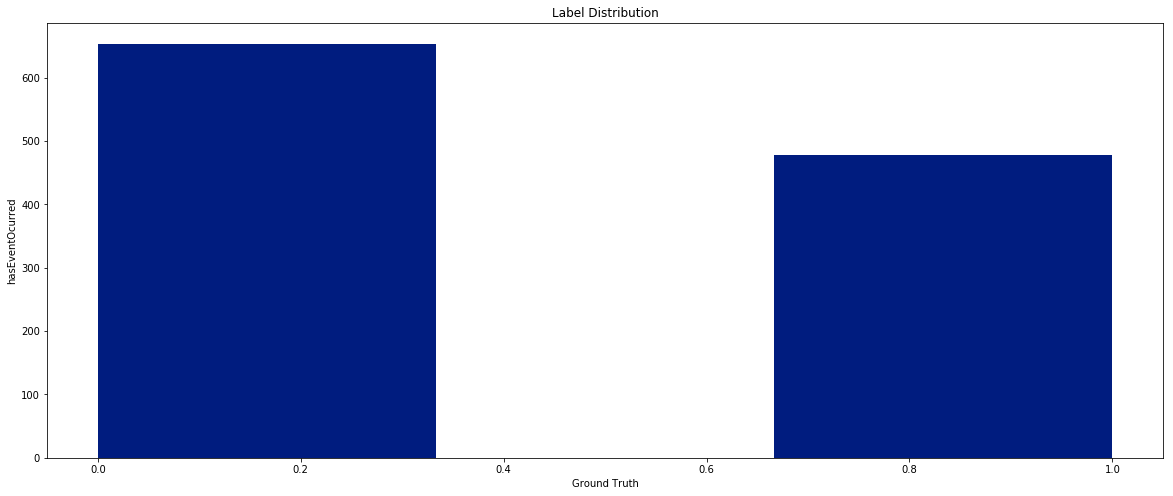

In [77]:
plt.title('Label Distribution')
plt.xlabel('Ground Truth')
plt.ylabel('hasEventOcurred')
_ = plt.hist(labels, bins=3, range=(0, 1))

In [78]:
# Tokenizer
nlp = spacy.load('en_core_web_sm')

# Generate sentence vectors
sentence_vectors = []
regexp = r'/[.,\/#!$%\^&\*;:{}=\-_`~()]/g'
num_sentences = len(news_articles)

for i, sentence in enumerate(news_articles):
    if i % 100 == 0:
        print (i, " / ", num_sentences, "done!")
    tokens = [t.text.lower() for t in nlp(sentence)]
    temp = []
    for token in tokens:
        vec = vector.get(token)
        if vec is None:
            vec = vector['unk']
        temp.append(vec)
    sentence_vectors.append(temp)
            

0  /  373 done!
100  /  373 done!
200  /  373 done!
300  /  373 done!


In [79]:
# For the sentence vector, currently, simply just use average of all words vectors
for i, vecs in enumerate(sentence_vectors):
    sentence_vectors[i] = np.mean(vecs, axis=0)

In [80]:
sentence_vectors = np.array(sentence_vectors)
print("Sentence vector shape -", sentence_vectors.shape)

Sentence vector shape - (373, 100)


In [81]:
df.index = np.arange(len(df))
df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,2021234,356,IND245,245.0,2016-01-11,2016,1,Riots/Protests,Protesters (India),NaN,...,Chennai,13.0878,80.2784,1,The Hindu,National,Members of the Micro Small and Medium Enterpri...,0,1542756327,IND
1,2031949,356,IND388,388.0,2016-01-19,2016,1,Riots/Protests,Protesters (India),NaN,...,Chennai,13.0878,80.2784,1,The Times of India (TOI),National,Students protested against the suicide of a Ph...,0,1542756337,IND
2,2032330,356,IND435,435.0,2016-01-20,2016,1,Riots/Protests,Protesters (India),Teachers (India),...,Chennai,13.0878,80.2784,1,The Hindu,National,Members of the Joint Action Council of College...,0,1542756337,IND
3,2032754,356,IND481,481.0,2016-01-21,2016,1,Riots/Protests,Protesters (India),Teachers (India),...,Chennai,13.0878,80.2784,1,The Hindu,National,Members of the Joint Action Council of College...,0,1542756338,IND
4,2033022,356,IND511,511.0,2016-01-22,2016,1,Riots/Protests,Protesters (India),NaN,...,Chennai,13.0878,80.2784,1,The Times of India (TOI),National,The Tamil Nadu Rajasthani Pravasi Ekta Sangh h...,0,1542756338,IND


In [82]:
vec_date = []
for date in dates:
    temp_df = df[df['event_date'] == date]
    if len(temp_df) == 0:
        vec_date.append(np.zeros(100))

    else:
        indices = list(temp_df.index)
        vec_date_temp = np.mean(sentence_vectors[indices].reshape(-1, 100), axis=0)
        vec_date.append(vec_date_temp)
    

In [83]:
num_days, days_window = 2, 2
history = 5
n = len(dates)

In [84]:
print(n)

1136


In [85]:
x, y = [], []
for i in range(history, n - num_days - days_window):
    x.append(vec_date[i - history: i])
    y.append(labels[i])

In [86]:
x, y = np.array(x), np.array(y)

In [87]:
print(x.shape, y.shape)

(1127, 5, 100) (1127,)


In [88]:
model = M.Sequential()
model.add(L.LSTM(50, input_shape=(5, 100)))
model.add(L.Dense(2))
model.add(L.Activation('softmax'))
opzr = opt.RMSprop(3e-5)
model.compile('rmsprop', loss=losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3_input (InputLayer)    (None, 5, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 30,302
Trainable params: 30,302
Non-trainable params: 0
_________________________________________________________________


In [89]:
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2)
ytrain, ytest = to_categorical(ytrain), to_categorical(ytest)

In [90]:
print('Train shape -', xtrain.shape)
print('Test shape -', xtest.shape)

Train shape - (901, 5, 100)
Test shape - (226, 5, 100)


In [91]:
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=16, epochs=50)

Train on 901 samples, validate on 226 samples
Epoch 1/50
901/901 [==============================] - 1s 1ms/step - loss: 0.6870 - acc: 0.5705 - val_loss: 0.6794 - val_acc: 0.5929
Epoch 2/50
901/901 [==============================] - 0s 392us/step - loss: 0.6874 - acc: 0.5605 - val_loss: 0.6781 - val_acc: 0.6106
Epoch 3/50
901/901 [==============================] - 0s 409us/step - loss: 0.6853 - acc: 0.5616 - val_loss: 0.6716 - val_acc: 0.6416
Epoch 4/50
901/901 [==============================] - 0s 386us/step - loss: 0.6831 - acc: 0.5760 - val_loss: 0.6689 - val_acc: 0.6416
Epoch 5/50
901/901 [==============================] - 0s 446us/step - loss: 0.6816 - acc: 0.5627 - val_loss: 0.6715 - val_acc: 0.6106
Epoch 6/50
901/901 [==============================] - 0s 447us/step - loss: 0.6767 - acc: 0.5860 - val_loss: 0.6671 - val_acc: 0.6327
Epoch 7/50
901/901 [==============================] - 0s 407us/step - loss: 0.6780 - acc: 0.5794 - val_loss: 0.6658 - val_acc: 0.6018
Epoch 8/50
901/901